In [22]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *

# Init data sizes and parametes of the PXM of ID16A

In [23]:
n = 512  # object size in each dimension
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
ndist = 4
distances = np.array([0.0029432,0.00306911,0.00357247,0.00461673])[:ndist] # [m]
magnification = 400
detector_pixelsize = 3.03751e-6
voxelsize = detector_pixelsize/magnification*2048/n  # object voxel size

ne = n+n//4
pad = n//8
show = True

path = f'/data/vnikitin/modeling/siemens{n}'


## Read data

In [24]:
data = np.load(f'{path}/data.npy')
psi = np.load(f'{path}/psi.npy')

# Construct operators


In [25]:
def Lop(psi):
    data = cp.zeros([1,ndist, ne, ne], dtype='complex64')
    for i in range(ndist):
        psir = psi.copy()                               
        psir = G(psir, wavelength, voxelsize, distances[i],'symmetric')        
        data[:, i] = psir
    return data

def LTop(data):
    psi = cp.zeros([1, ne, ne], dtype='complex64')
    for j in range(ndist):
        datar = data[:, j].copy()
        datar = GT(datar, wavelength, voxelsize, distances[j],'symmetric')        
        psi += datar
    return psi

def Cfop(e):
    res = e.copy()
    res[:,:,pad:ne-pad,pad:ne-pad] = 0
    return res

def CfTop(e):
    res = e.copy()
    res[:,:,pad:ne-pad,pad:ne-pad] = 0
    return res

# adjoint tests
tmp = cp.array(data).copy().astype('complex64')
arr1 = cp.pad(tmp[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     

arr2 = Lop(arr1)
arr3 = LTop(arr2)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')


(1725481.5-0.0038604140281677246j)==
(1725481.5+5.481321750266943e-06j)


## V1 problem: $$\||L(\psi)|-(d+C_f(e))\|_2^22$$

## Gradients

#### $$\nabla F=2 \left(L^*\left( L(\psi)-\tilde d\right)\right).$$
#### where $$\tilde d = (d+C_f(e)) \frac{L(\psi)}{|L(\psi))|}$$
#### $$\nabla_e F=-2 \left(C_f^*\left( |L(\psi)|-(d+L_f(e))\right)\right).$$



In [26]:
def gradientF(vars,d):
    (psi,e) = (vars['psi'],vars['e'])
    Lpsi = Lop(psi)
    td = (d+Cfop(e))*(Lpsi/np.abs(Lpsi))
    res = 2*LTop(Lpsi - td) 
    return res

def gradiente(vars,d):
    (psi,e) = (vars['psi'],vars['e'])
    Lpsi = Lop(psi)
    res = -2*CfTop(np.abs(Lpsi)-(d+Cfop(e)))
    return res    



##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z))) \right\rangle$$
##### $$+\mathsf{Re}\langle C_f(\Delta_{e_1}),C_f(\Delta_{e_2})\rangle-\langle C_f(\Delta_{e_1}),\mathsf{Re}(\overline{l_0}\cdot L(z))\rangle-\langle C_f(\Delta_{e_2}),\mathsf{Re}(\overline{l_0}\cdot L(y))\rangle$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=(d+C_f(e))/|L(x_0)|$$


In [27]:
def hessianF(hpsi,hpsi1,hpsi2,e,de1,de2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/np.abs(Lpsi)
    d0 = (data+Cfop(e))/np.abs(Lpsi)
    v1 = np.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = np.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))        
    v3 = np.sum(Cfop(de1)*Cfop(de2))-np.sum(Cfop(de1)*reprod(l0,Lpsi2))-np.sum(Cfop(de2)*reprod(l0,Lpsi1))
    
    return 2*(v1+v2+v3)

In [28]:
def calc_beta(vars,grads,etas,d):
    (psi,e,rho) = (vars['psi'],vars['e'],vars['rho'])
    (dpsi1,de1) = (grads['psi']*rho[0],grads['e']*rho[1])
    (dpsi2,de2) = (etas['psi']*rho[0],etas['e']*rho[1])    
    top = hessianF(psi, dpsi1, dpsi2,e,de1,de2, d)    
    bottom = hessianF(psi, dpsi2, dpsi2,e,de2,de2,d)
    return top/bottom

def calc_alpha(vars,grads,etas,d):    
    (psi,e,rho) = (vars['psi'],vars['e'],vars['rho'])
    (dpsi1,de1) = (grads['psi'],grads['e'])
    (dpsi2,de2) = (etas['psi'],etas['e'])    
    top = -redot(dpsi1,dpsi2)-redot(de1,de2)  

    (dpsi2,de2) = (etas['psi']*rho[0],etas['e']*rho[1])    
    bottom = hessianF(psi, dpsi2, dpsi2,e,de2,de2,d)
    return top/bottom, top, bottom

### Initial guess for reconstruction (Paganin)

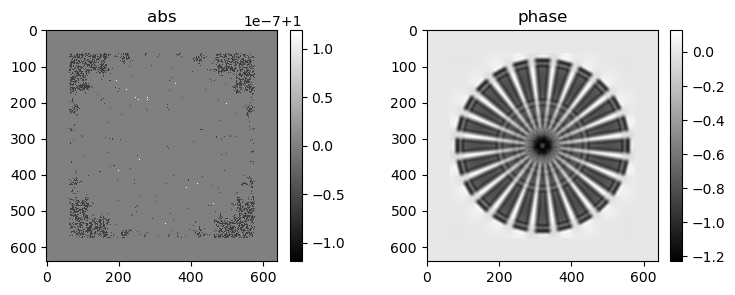

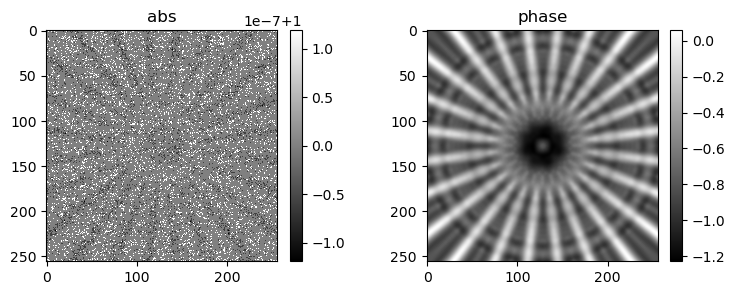

In [29]:
def rec_init(rdata):
    recMultiPaganin = cp.zeros([1,ndist,n,n],dtype='float32')
    for j in range(0,ndist):
        rdatar = cp.array(rdata[:,j:j+1])
        r = multiPaganin(rdatar,
                            distances[j:j+1], wavelength, voxelsize,  24.05, 1e-3)    
        recMultiPaganin[:,j] = r
        
    recMultiPaganin = np.sum(recMultiPaganin,axis=1)/ndist    
    recMultiPaganin = np.exp(1j*recMultiPaganin)
    return recMultiPaganin

rec_paganin = rec_init(data)
rec_paganin = np.pad(rec_paganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'constant',constant_values=1)
mshow_polar(rec_paganin[0],show)
mshow_polar(rec_paganin[0,ne//2-128:ne//2+128,ne//2-128:ne//2+128],show)

## debug functions

In [ ]:
def plot_debug2(vars,etas,top,bottom,alpha,data):
    if show==False:
        return
    (psi,e,rho) = (vars['psi'],vars['e'],vars['rho'])
    (dpsi2,de2) = (etas['psi'],etas['e'])    
    npp = 5
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
        et = e+(alpha*k/(npp-1))*rho[1]*de2
        fpsit = np.abs(Lop(psit))-(data+Cfop(et))
        errt[k] = np.linalg.norm(fpsit)**2
        
    t = alpha*(cp.arange(2*npp))/(npp-1)
    tmp = np.abs(Lop(psi))-(data+Cfop(e))
    errt2 = np.linalg.norm(tmp)**2-top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()


def vis_debug(vars,data,i):
    mshow_polar(vars['psi'][0],show)    
    mshow_polar(vars['psi'][0,ne//2-n//4:ne//2+n//4,ne//2+n//4:ne//2+n//2+n//4],show)    
    
def err_debug(vars, grads, data):    
    (psi,e) = (vars['psi'], vars['e'])
    tmp = np.abs(Lop(psi))-(data+Cfop(e))
    err = np.linalg.norm(tmp)**2
    
    return err

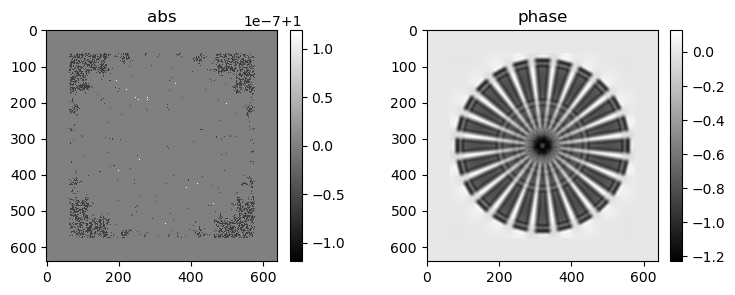

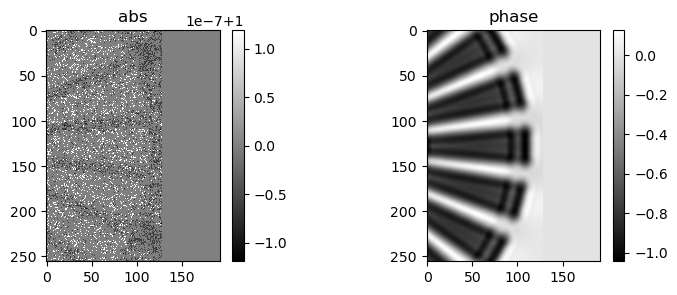

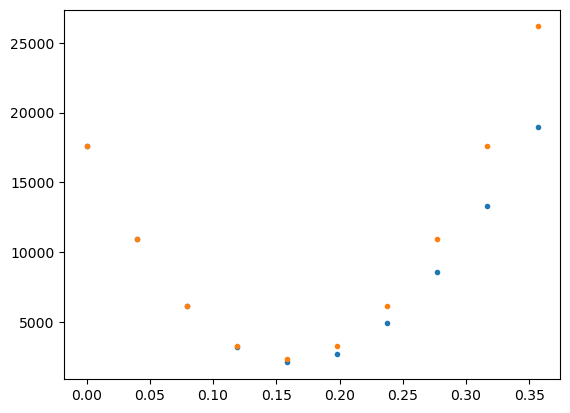

0) alpha=0.15851,[1, 2] err=2.10595e+03
32) alpha=0.21448,[1, 2] err=3.65339e+00
64) alpha=0.23505,[1, 2] err=4.96056e-01
96) alpha=0.24646,[1, 2] err=1.57487e-01


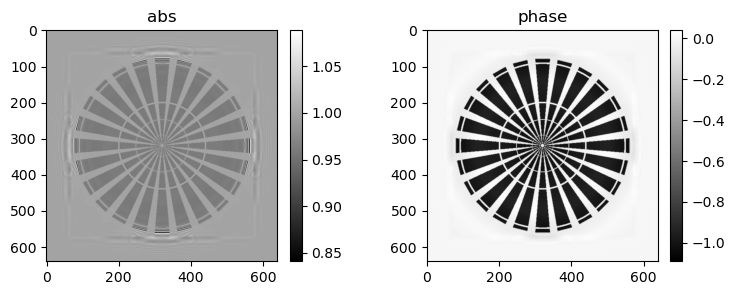

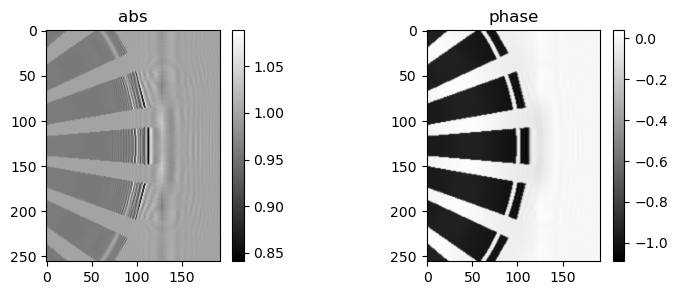

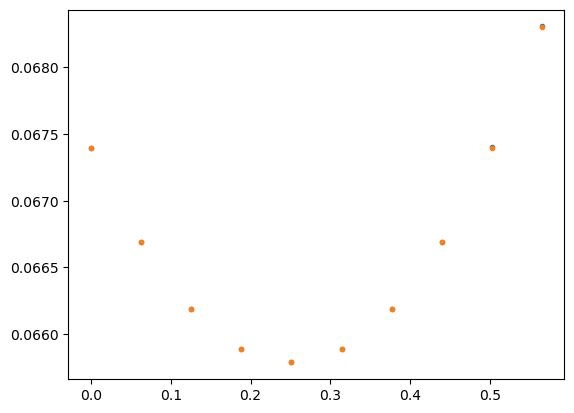

128) alpha=0.25125,[1, 2] err=6.57865e-02
160) alpha=0.24336,[1, 2] err=2.91502e-02
192) alpha=0.24735,[1, 2] err=1.84599e-02
224) alpha=0.25188,[1, 2] err=1.17371e-02


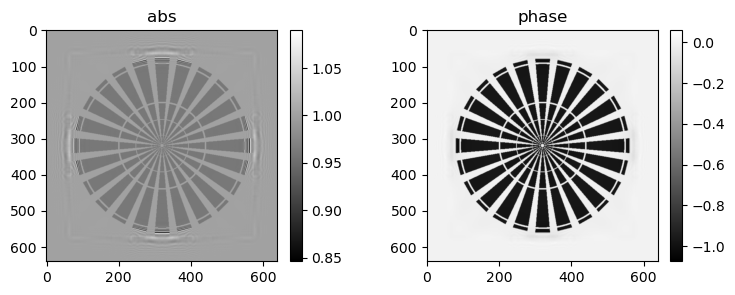

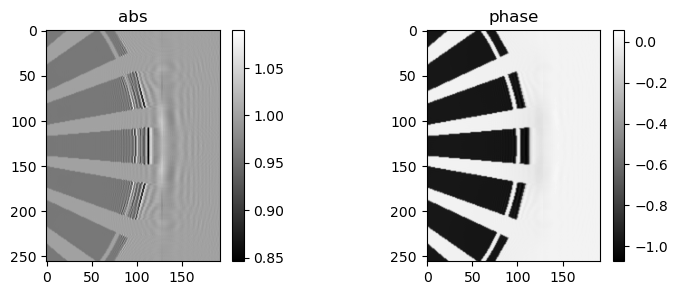

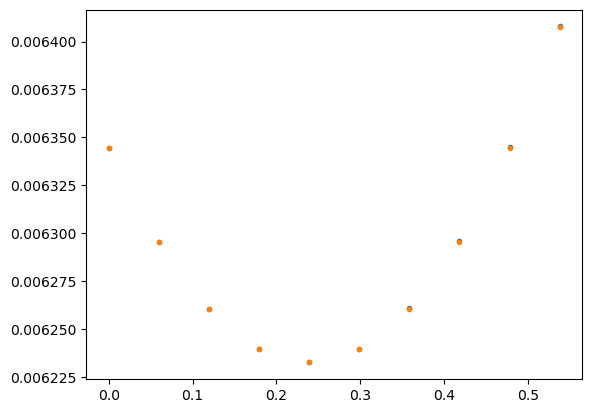

256) alpha=0.23904,[1, 2] err=6.23261e-03
288) alpha=0.24595,[1, 2] err=3.96266e-03
320) alpha=0.22782,[1, 2] err=2.72372e-03
352) alpha=0.21920,[1, 2] err=1.79798e-03


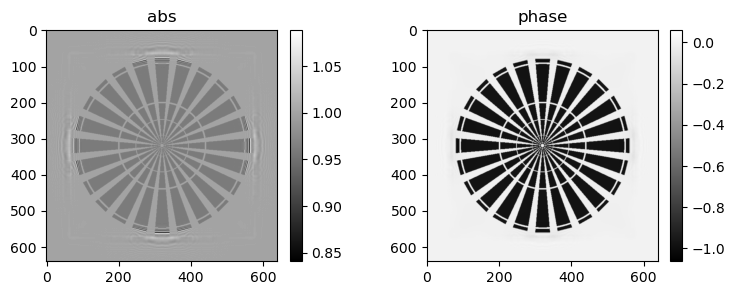

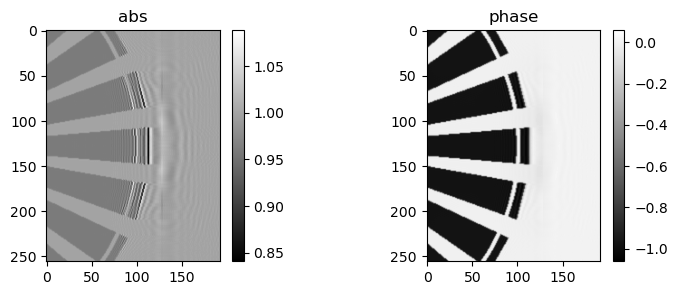

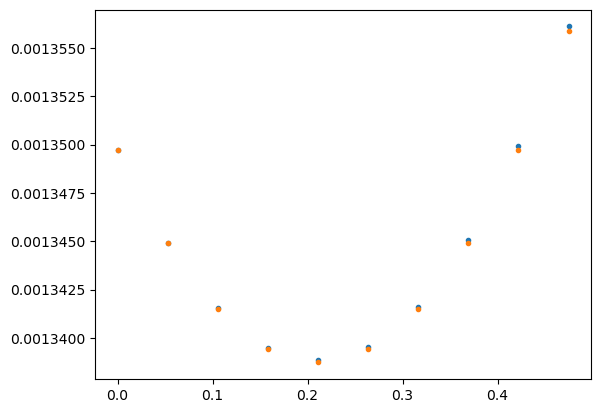

384) alpha=0.21100,[1, 2] err=1.33885e-03
416) alpha=0.18978,[1, 2] err=1.08465e-03
448) alpha=0.18267,[1, 2] err=9.29756e-04
480) alpha=0.17561,[1, 2] err=7.83718e-04


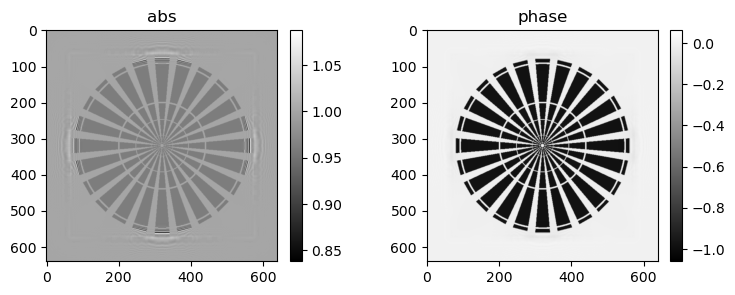

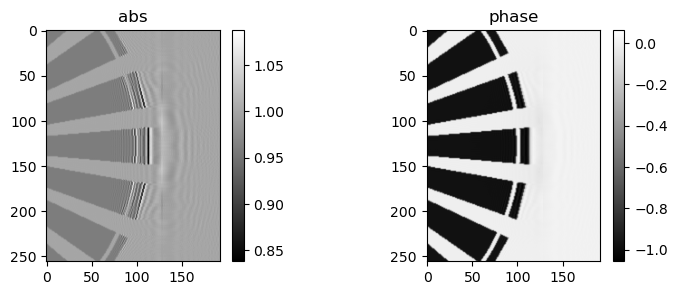

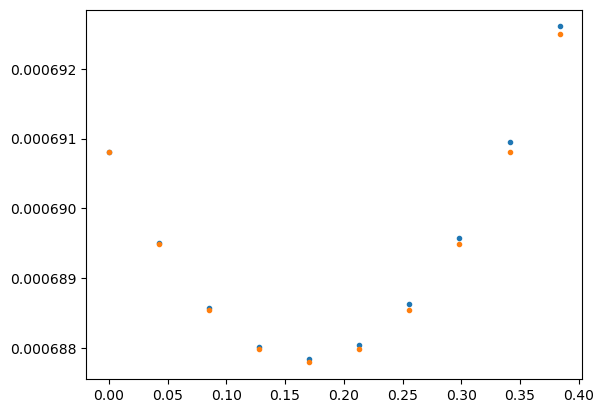

512) alpha=0.17053,[1, 2] err=6.87833e-04
544) alpha=0.16246,[1, 2] err=6.05013e-04
576) alpha=0.15892,[1, 2] err=5.73739e-04
608) alpha=0.15287,[1, 2] err=5.57863e-04


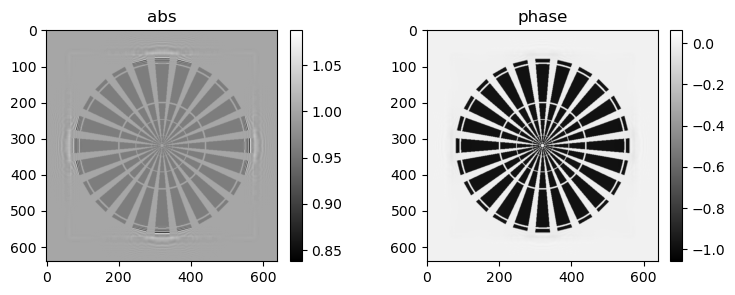

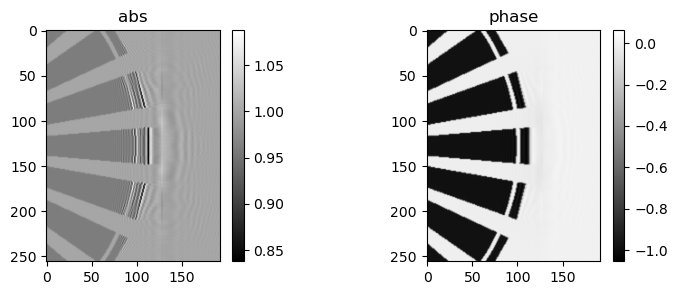

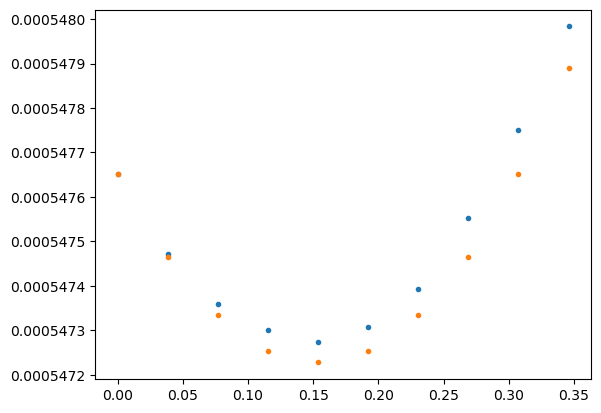

640) alpha=0.15375,[1, 2] err=5.47275e-04
672) alpha=0.14840,[1, 2] err=5.37835e-04
704) alpha=0.14953,[1, 2] err=5.30144e-04
736) alpha=0.14983,[1, 2] err=5.23026e-04


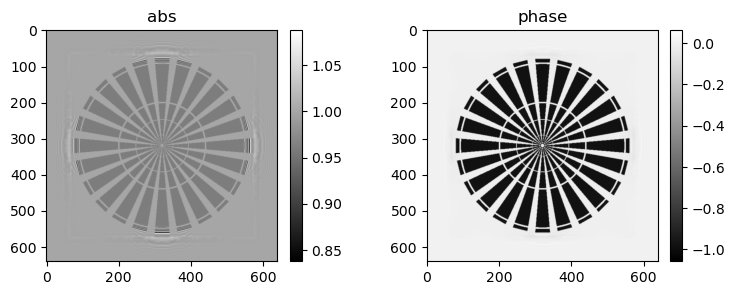

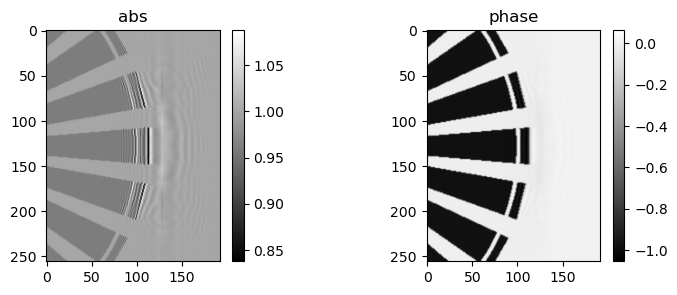

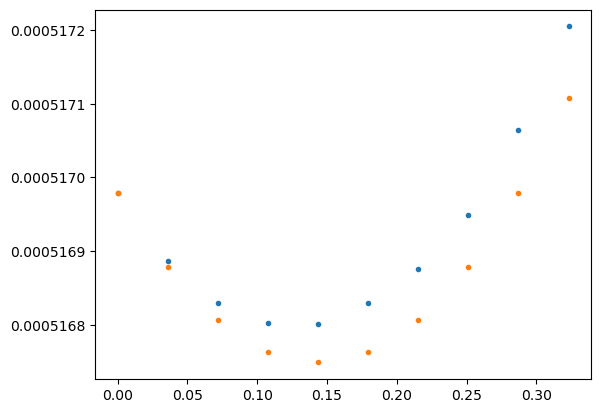

768) alpha=0.14356,[1, 2] err=5.16800e-04
800) alpha=0.14300,[1, 2] err=5.11014e-04
832) alpha=0.14394,[1, 2] err=5.05968e-04
864) alpha=0.14256,[1, 2] err=5.00833e-04


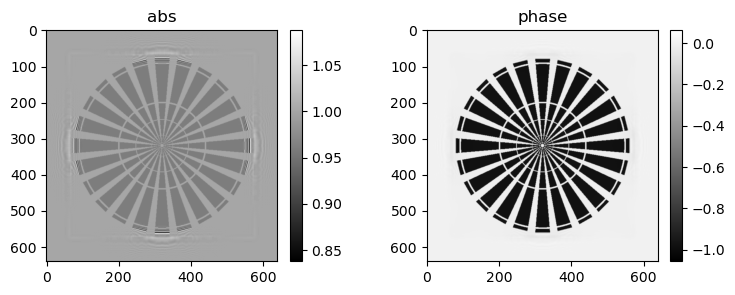

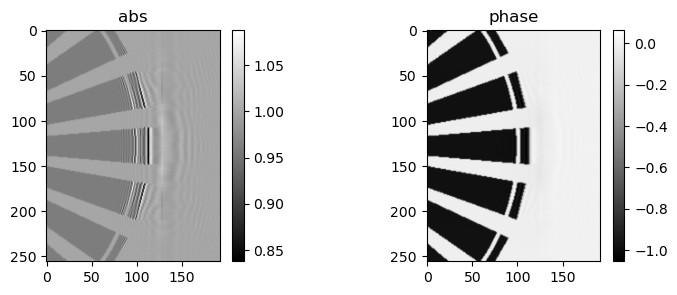

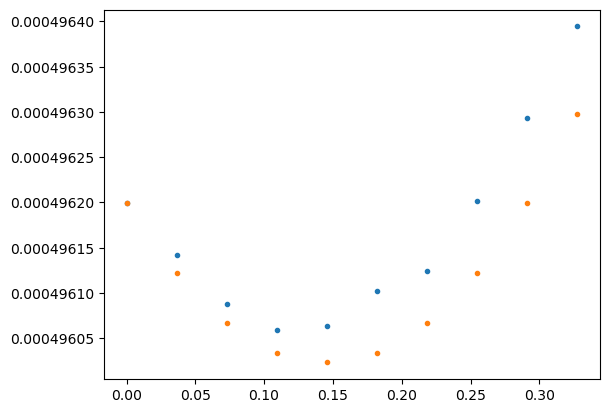

896) alpha=0.14564,[1, 2] err=4.96063e-04
928) alpha=0.14116,[1, 2] err=4.91481e-04
960) alpha=0.13856,[1, 2] err=4.87313e-04
992) alpha=0.13799,[1, 2] err=4.83221e-04


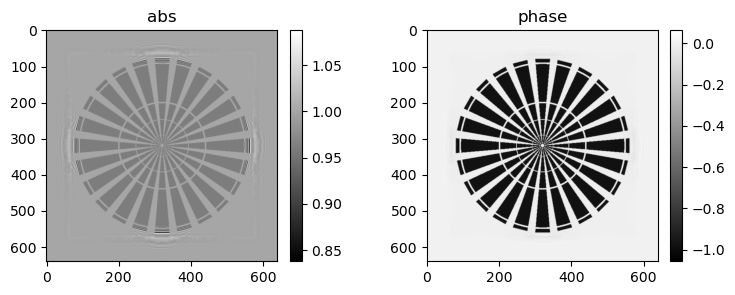

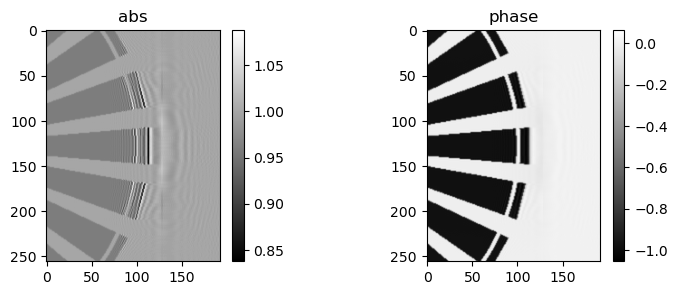

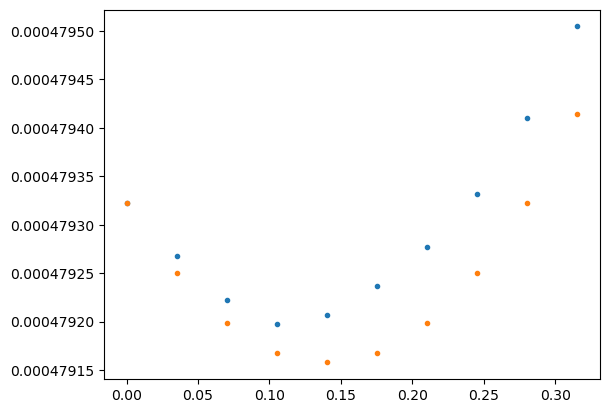

1024) alpha=0.14022,[1, 2] err=4.79207e-04


In [31]:
def cg_holo(data, vars, pars):
    
    # take sqrt of data
    data = np.sqrt(data)    
    
    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    

    grads ={}
    for i in range(pars['niter']):          

        # debug: visualization of reconstructions
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, data, i) 
        
        # gradients
        grads['psi'] = vars['rho'][0]*gradientF(vars,data)        
        grads['e'] = vars['rho'][1]*gradiente(vars,data)        

        # calc eta and beta
        if i==0:
            etas = {}
            etas['psi'] = -grads['psi']
            etas['e'] = -grads['e']
        else:      
            beta = calc_beta(vars, grads, etas, data)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['e'] = -grads['e'] + beta*etas['e']

        # calc alpha
        alpha,top,bottom = calc_alpha(vars, grads, etas, data) 

        # debug: minimization function plot
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            plot_debug2(vars,etas,top,bottom,alpha,data)

        # update variables
        vars['psi'] += vars['rho'][0]*alpha*etas['psi']
        vars['e'] += vars['rho'][1]*alpha*etas['e']
        
        # debug: calc minimization function
        if i % pars['err_step'] == 0:
            err = err_debug(vars, grads, data)    
            print(f'{i}) {alpha=:.5f},{vars['rho']} {err=:1.5e}',flush=True)
            erra[i] = err
            alphaa[i] = alpha                

    return vars,erra,alphaa

vars = {}
vars['psi'] = cp.array(rec_paganin).copy()
vars['e'] = 1+0*cp.pad(cp.sqrt(cp.array(data)),((0,0),(0,0),(pad,pad),(pad,pad)),'symmetric')
vars['e'][:,:,pad:ne-pad,pad:ne-pad]=0
vars['rho'] = [1,2]# weights for gradients
pars = {'niter': 1025, 'err_step':32, 'vis_step': 128}

#note data should be padded with 0!
data_rec = cp.pad(cp.array(data),((0,0),(0,0),(pad,pad),(pad,pad)))
vars,erra,alphaa = cg_holo(data_rec, vars, pars)    